## Predicted probabilities in classification
- often more important than the predicted class
- example: health care
    - predict if a patient is sick or not
    - the predicted probability describes how confident the model is vs. a simple yes-no label
        - 51% and 99% probabilities both translate to a yes label
- another example: banking
    - predict if a customer will be able to pay back a loan
    - same issue: predicted probability is usually better than the yes-no label
- third example: any classification problem that is followed by a resource-intensive intervention
    - e.g., treatment is expensive so you want to rank the patients
        - can't do that with yes-no labels, but you can with probabilities

## Can we trust the predicted probabilities?
- take all points in your test set
- collect points with a predicted probability between x% and x+epsilon%
- check the true labels of those points and calculate what fraction of points are in class 1
- if the fraction is close to x%, you can trust the predicted probabilities
- otherwise the probabilities are off and you need to calibrate them

## Example
- adult dataset, 1990 census data, do people earn less or more than 50k annually?
- 75% of people earn less than 50k and classifiers have a trouble pushing the accuracy near 90%
- tried a couple of classifiers
    - some were well-calibrated, some weren't
- I take the uncalibrated classifier and applied sklearn's `CalibratedClassifierCV` to it
- read more [here](https://scikit-learn.org/stable/modules/calibration.html#calibration) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html)

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
from itertools import combinations, product

In [37]:
### adult dataset

# train data
df = pd.read_csv('data/adult_data.csv')
label = 'gross-income'
l_encoder = LabelEncoder().fit((df[label]))
print(l_encoder.classes_)
y = l_encoder.transform(df[label])
df.drop(columns=[label],inplace=True)
X = df
ftr_names = X.columns
print(X.head())
print(y)

# test data
df_test = pd.read_csv('data/adult_test.csv')
y_test = l_encoder.transform(df_test[label])
df_test.drop(columns=[label],inplace=True)
X_test = df_test
print(X.shape,X_test.shape)

[' <=50K' ' >50K']
   age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  
0          2174             0              40   United-St

In [38]:
def ML_pipeline(X,y,X_test,y_test,random_state,n_folds,param_grid,classifier):
    # splitter for X and y
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    pipe = make_pipeline(preprocessor,classifier)
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=6,verbose=10)
    # do kfold CV on training data
    grid.fit(X, y)
    # return predicted probabilities
    predicted_proba = grid.predict_proba(X_test)
    test_score = grid.score(X_test,y_test)
    return grid, predicted_proba, test_score

In [3]:
# logistic regression with class weight
param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}
classifier = LogisticRegression(penalty='l2',max_iter = 10000,class_weight='balanced')
lrw_grid, lrw_probas, lrw_test_score = ML_pipeline(X,y,X_test,y_test,42,5,param_grid,classifier)
print(lrw_grid.best_params_)
print(lrw_grid.best_score_)
print(lrw_test_score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    5.8s
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:   10.7s remaining:    5.0s
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed:   12.9s remaining:    3.2s
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed:   14.7s remaining:    1.3s
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:   15.6s finished


{'logisticregression__C': 1}
0.8106016704070595
0.8088569498188072


In [4]:
# logistic regression without class weight
param_grid = {'logisticregression__C' : [0.01, 0.1, 1, 10, 100]}
classifier = LogisticRegression(penalty='l2',max_iter = 10000)
lr_grid, lr_probas, lr_test_score = ML_pipeline(X,y,X_test,y_test,42,5,param_grid,classifier)
print(lr_grid.best_params_)
print(lr_grid.best_score_)
print(lr_test_score)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.8s
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:   10.0s remaining:    4.7s
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed:   12.2s remaining:    3.0s
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed:   14.4s remaining:    1.2s
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:   15.2s finished


{'logisticregression__C': 0.1}
0.8521236821386522
0.8532031202014618


In [5]:
# random forest with class weight
param_grid = {'randomforestclassifier__min_samples_split' : [2,4,8,16,32,64,128],
              'randomforestclassifier__max_features' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
classifier = RandomForestClassifier(n_estimators = 100,random_state=42,class_weight='balanced')
rfw_grid, rfw_probas, rfw_test_score = ML_pipeline(X,y,X_test,y_test,42,5,param_grid,classifier)
print(rfw_grid.best_params_)
print(rfw_grid.best_score_)
print(rfw_test_score)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   17.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   17.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   54.9s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  7.1min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  8.5min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  9.7min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 11.3min
[Parallel(

{'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__min_samples_split': 4}
0.8590645773280503
0.8538787543762668


In [6]:
# random forest without class weight
param_grid = {'randomforestclassifier__min_samples_split' : [2,4,8,16,32,64,128],
              'randomforestclassifier__max_features' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
classifier = RandomForestClassifier(n_estimators = 100,random_state=42)
rf_grid, rf_probas, rf_test_score = ML_pipeline(X,y,X_test,y_test,42,5,param_grid,classifier)
print(rf_grid.best_params_)
print(rf_grid.best_score_)
print(rf_test_score)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   20.1s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   20.4s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   55.8s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  3.3min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  5.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  8.4min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  9.6min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 11.3min
[Parallel(

{'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__min_samples_split': 64}
0.8677252139078486
0.8664701185430871


In [ ]:
# # MLP
# param_grid = {'mlpclassifier__alpha': [0.01, 0.1, 1, 10, 100],
#               'mlpclassifier__hidden_layer_sizes': [p for p in product([2,4,8,16,32],repeat=2)]}
# classifier = MLPClassifier()
# mlp_grid, mlp_probas, mlp_test_score = ML_pipeline(X,y,X_test,y_test,42,5,param_grid,classifier)
# print(mlp_probas)
# print(mlp_grid.best_params_)
# print(mlp_grid.best_score_)
# print(mlp_test_score)

In [ ]:
# # SVC
# param_grid = {'svc__C': [0.01, 0.1, 1, 10, 100],
#              'svc__gamma': [0.01, 0.1, 1, 10, 100]}
# classifier = SVC(probability=True)
# svc_grid, svc_probas, svc_test_score = ML_pipeline(X,y,X_test,y_test,42,5,param_grid,classifier)
# print(svc_probas)
# print(svc_grid.best_params_)
# print(svc_grid.best_score_)
# print(svc_test_score)

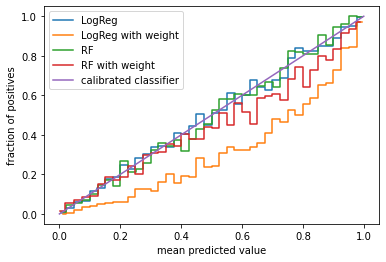

In [7]:
probs = [lr_probas,lrw_probas,rf_probas,rfw_probas]
labels = ['LogReg','LogReg with weight', 'RF', 'RF with weight']

for i in range(len(probs)):
    # let's create the reliability curves
    bins = np.linspace(0,1,41)
    indices = np.digitize(probs[i][:,1],bins)
    mean_pred_value = np.zeros(len(bins)-1)
    fraction_of_positives = np.zeros(len(bins)-1)
    
    for j in range(len(bins)-1):
        mask = indices == j+1
        mean_pred_value[j] = np.mean(probs[i][mask,1])
        fraction_of_positives[j] = np.sum(y_test[mask])/len(y_test[mask])
        
    plt.step(mean_pred_value,fraction_of_positives,where='mid',label=labels[i])
    
plt.plot([0,1],[0,1],label='calibrated classifier')
plt.legend()
plt.xlabel('mean predicted value')
plt.ylabel('fraction of positives')
plt.show()
    

**Calibrated Classifier**

Given the predicted probabilities of a model f(x), we pass these through a sigmoid:

### $P(y=1|f) = \frac{1}{1+exp^{-(Af+B)}}$,

where A and B are fitted using an independent calibration set. Do not use the same set used for training because that will introduce a bias to the model.

See [this paper](https://dl.acm.org/doi/pdf/10.1145/1102351.1102430) for more details.


In [33]:
# let's fix the logistic regression classifier with weights
from sklearn.calibration import CalibratedClassifierCV

def ML_pipeline_calibrated(X,y,X_test,y_test,random_state,n_folds,param_grid,classifier):
    # the CalibratedClassifierCV should not be used on the same points used for training the model!
    # so we need to split X, y
    # X_train, y_train are used to train the model
    # X_cal and y_cal are used to calibrate it
    X_train, X_cal, y_train, y_cal = train_test_split(X,y,test_size=0.2,random_state=42)
    
    # splitter for X_train and y_train
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    cat_ftrs = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
    cont_ftrs = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']
    # one-hot encoder
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
    # standard scaler
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, cont_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])
    X_train_prep = preprocessor.fit_transform(X_train)
    X_cal_prep = preprocessor.transform(X_cal)
    X_test_prep = preprocessor.transform(X_test)
    
    # prepare gridsearch
    grid = GridSearchCV(classifier, param_grid=param_grid,cv=kf, return_train_score = True,n_jobs=6,verbose=10)
    # do kfold CV on training data
    grid.fit(X_train_prep, y_train)
    # return predicted probabilities
    predicted_proba_uncal = grid.predict_proba(X_test_prep)
    test_score_uncal = grid.score(X_test_prep,y_test)
        
    # calibrate it
    cal_class_sig = CalibratedClassifierCV(grid.best_estimator_, cv = 'prefit', method='sigmoid')
    cal_class_sig.fit(X_cal_prep,y_cal)
    predicted_proba_sig = cal_class_sig.predict_proba(X_test_prep)
    test_score_sig = cal_class_sig.score(X_test_prep,y_test)
    
    return predicted_proba_uncal, test_score_uncal, predicted_proba_sig, test_score_sig 



In [34]:
# logistic regression with class weight
param_grid = {'C' : [0.01, 0.1, 1, 10, 100]}
classifier = LogisticRegression(penalty='l2',max_iter = 10000,class_weight='balanced')
lr_proba_uncal, lr_test_score_uncal, lr_proba_sig, lr_test_score_sig = ML_pipeline_calibrated(X,y,X_test,y_test,42,5,param_grid,classifier)
print(lr_test_score_uncal)
print(lr_test_score_sig)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.7s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done  17 out of  25 | elapsed:    7.5s remaining:    3.5s
[Parallel(n_jobs=6)]: Done  20 out of  25 | elapsed:    8.0s remaining:    2.0s
[Parallel(n_jobs=6)]: Done  23 out of  25 | elapsed:   10.6s remaining:    0.9s
[Parallel(n_jobs=6)]: Done  25 out of  25 | elapsed:   10.8s finished


0.808549843375714
0.8514219028315214


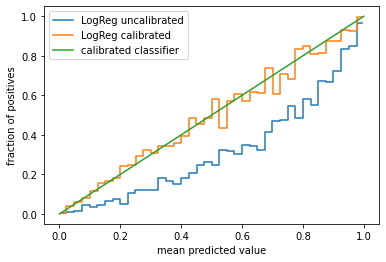

In [35]:
probs = [lr_proba_uncal,lr_proba_sig]
labels = ['LogReg uncalibrated', 'LogReg calibrated']

for i in range(len(probs)):
    # let's create the reliability curves
    bins = np.linspace(0,1,41)
    indices = np.digitize(probs[i][:,1],bins)
    mean_pred_value = np.zeros(len(bins)-1)
    fraction_of_positives = np.zeros(len(bins)-1)
    
    for j in range(len(bins)-1):
        mask = indices == j+1
        mean_pred_value[j] = np.mean(probs[i][mask,1])
        fraction_of_positives[j] = np.sum(y_test[mask])/len(y_test[mask])
        
    plt.step(mean_pred_value,fraction_of_positives,where='mid',label=labels[i])
    
plt.plot([0,1],[0,1],label='calibrated classifier')
plt.legend()
plt.xlabel('mean predicted value')
plt.ylabel('fraction of positives')
plt.show()
    